In [1]:
import Modules.SQcircuit_extensions as sq_ext
import SQcircuit as sq
import qutip as qt
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import importlib

%matplotlib ipympl

importlib.reload(sq_ext)
importlib.reload(sq)

<module 'SQcircuit' from '/home/gabriel/anaconda3/envs/tunable-capacitive-coupling-flux-qubits/lib/python3.8/site-packages/SQcircuit/__init__.py'>

# Single circuit

This notebook studies the circuit proposed by KIT. It's lumped element model is:
<img src='Other/Single qubit 4 nodes CC coupled to ground.jpg' width='500'>


## Define the circuit

In [2]:
# Fundamental constants
h    = 6.626e-34
GHz = 1e9
e0   = 1.602e-19
Φ_0 = h/(2*e0)

# Circuit parameters
Csh = 15
C   = 15
Cg  = 10
CJ  = 3
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0
l = Lq*(Lq+4*Lr) - 4*Δ**2

# Initialize loop(s)
loop = sq.Loop(0.0)  # "Value" corresponds to phiExt / phi0 threading the loop (can change later)
elements = {
    # Without ground node
    (0, 3): [sq.Inductor (Lr,       'nH')],
    (0, 1): [sq.Capacitor(C,        'fF')],
    (0, 2): [sq.Capacitor(C,        'fF')],
    (3, 1): [sq.Inductor (Lq/2 - Δ, 'nH',  loops=[loop])],
    (1, 2): [sq.Junction (EJ,       'GHz', loops=[loop]), sq.Capacitor(CJ+Csh, 'fF')],
    (2, 3): [sq.Inductor (Lq/2 + Δ, 'nH',  loops=[loop])],

    # With ground node
    # (0, 1): [sq.Capacitor(Cg,       'fF')],
    # (1, 4): [sq.Inductor (Lr,       'nH')],
    # (1, 2): [sq.Capacitor(C,        'fF')],
    # (1, 3): [sq.Capacitor(C,        'fF')],
    # (4, 2): [sq.Inductor (Lq/2 - Δ, 'nH',  loops=[loop])],
    # (2, 3): [sq.Junction (EJ,       'GHz', loops=[loop]), sq.Capacitor(CJ+Csh, 'fF')],
    # (3, 4): [sq.Inductor (Lq/2 + Δ, 'nH',  loops=[loop])],
}

# Create the circuits
circuit = sq.Circuit(elements)
circuit.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [3]:
circuit.S

array([[ 1.72026745e+01,  5.05170698e+01, -4.83005796e-01],
       [ 1.82026745e+01,  4.95170698e+01,  5.16994204e-01],
       [ 3.45304159e+08,  3.07829540e+01,  7.99662964e-03]])

# Equivalent circuits

In [4]:
# loop_eq = sq.Loop(0.0)
# equiv_elements = {
#     (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor ( 1/(  1/(l/Lq) -  1/(l/Δ)  ), 'nH')],
#     (1, 2): [sq.Inductor (l/Δ, 'nH')],
#     (0, 2): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), sq.Inductor ( 1/(  1/(l/(Lq+4*Lr)) -  1/(l/Δ)  ), 'nH',  loops=[loop_eq]), sq.Junction (EJ, 'GHz', loops=[loop_eq])],
# }
# circ_equiv = sq.Circuit(equiv_elements )
# circ_equiv.description()

In [5]:
loop_uncoupled = sq.Loop(0.0)
uncoupled_elements = {
    (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor ( 1/(  1/(l/Lq) -  1/(l/Δ)  ), 'nH')],
    # (1, 2): [sq.Inductor (l/Δ, 'nH')],
    (0, 2): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), sq.Inductor ( 1/(  1/(l/(Lq+4*Lr)) -  1/(l/Δ)  ), 'nH',  loops=[loop_uncoupled]), sq.Junction (EJ, 'GHz', loops=[loop_uncoupled])],
}
circ_uncoupled = sq.Circuit(uncoupled_elements )
circ_uncoupled.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [6]:
resonator_elements = {
    (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor (l/Lq, 'nH')],
}
resonator = sq.Circuit(resonator_elements )
resonator.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
loop_fluxonium = sq.Loop(0.0)
fluxonium_elements = {
    (0, 1): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]), sq.Junction(EJ, 'GHz', loops=[loop_fluxonium])],
    # (0, 1): [sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]), sq.Junction(EJ, 'GHz', loops=[loop_fluxonium], cap=sq.Capacitor(C/2 + Csh + CJ, 'fF'))],
}
fluxonium = sq.Circuit(fluxonium_elements)
fluxonium.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Resonator spectrum

In [8]:
L_r = l/Lq * 1e-9
C_r = C/2 * 1e-15
w_r = 1/np.sqrt(L_r*C_r) / 2 / np.pi / 1e9
E_harm = w_r * np.arange(0,8)
E_harm

array([ 0.        ,  7.2083882 , 14.41677639, 21.62516459, 28.83355279,
       36.04194098, 43.25032918, 50.45871738])

## Potential energy and eigenstates resoantor

In [ ]:
E_L_r = (Φ_0/(2*np.pi))**2/L_r / h

φ_r = np.linspace(-3,3,200)
n_eig = 2

V_r = 0.5 * E_L_r * (φ_r)**2

resonator.set_trunc_nums([20])
_, _ = resonator.diag(n_eig)

states_r = [resonator.eig_phase_coord(k=i, grid=[φ_r/2/np.pi]) for i in range(n_eig)]

fig, ax = plt.subplots()
ax.plot(φ_r, (V_r-V_r.min())/1e9, 'k:' )
[ax.plot(φ_r, np.abs(state)**2) for state in states_r]
ax.set_ylim([-.1,3])
fig.show()

## Potential energy and eigenstates of the fluxonium


In [9]:
L_q = l / (Lq + 4*Lr) * 1e-9
E_J = EJ * 1e9

In [10]:
E_L_f = (Φ_0/(2*np.pi))**2/L_q / h
E_C = e0**2 / (2*(C/2 + Csh + CJ)*1e-15) / h

In [11]:
print(E_L_f/GHz, E_C/GHz, E_J/GHz)

6.539994179227587 0.7594573959979404 10.0


In [ ]:
φ_q = np.linspace(-3,3,200)
φ_ext = np.pi
# V = 0.5 * 1/L_q * (Φ_q)**2 - E_J * np.cos((Φ_q-Φ_ext)*2*np.pi)
V = 0.5 * E_L_f * (φ_q)**2 - E_J * np.cos(φ_q-φ_ext)

n_eig = 2
fluxonium.set_trunc_nums([20])
loop_fluxonium.set_flux(φ_ext/2/np.pi)
_, _ = fluxonium.diag(n_eig)
states_f = [fluxonium.eig_phase_coord(k=i, grid=[φ_q/2/np.pi]) for i in range(n_eig)]


fig, ax = plt.subplots()
ax.plot(φ_q, (V-V.min())/1e9, 'k:' )

[ax.plot(φ_q, np.abs(state)**2) for state in states_f]
ax.set_ylim([-.1,3])
fig.show()

## Spectrum vs external flux

In [ ]:
circuit.set_trunc_nums([1, 3, 10])
fluxonium.set_trunc_nums([10])

# spectrum of the circuit
phi = np.linspace(0,1,100)
n_eig=8
spec = np.zeros((n_eig, len(phi)))
E_qubit = np.zeros((n_eig, len(phi)))

eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))
for i in range(len(phi)):
    # set the external flux for the loop
    loop_fluxonium.set_flux(phi[i])
    loop.set_flux(phi[i])
    # diagonalize the circuit
    spec[:, i] = circuit.diag(n_eig)[0]
    E_qubit[:, i] = fluxonium.diag(n_eig)[0]

fig, ax = plt.subplots(dpi=150)
for i in range(n_eig):
    ax.plot(phi, spec[i,:]- spec[0,:], color=eig_colors[i], linewidth=2)
for i in range(n_eig//2):
    ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' )
    ax.plot(phi, E_qubit[i,:]- E_qubit[0,:], color='r', linestyle = ':')

ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
ax.set_ylabel(r"$f_i-f_0$[GHz]", fontsize=13)
fig.show()

## Eigenstates of the circuit in phase base

In [2]:
circuit.set_trunc_nums([1,15,15])

# creat the phase grid
phi1 = 0
phi2 = np.linspace(-0.005, 0.005, 100)
phi3 = np.linspace(-0.5, 0.5  , 100)
grid = [phi1, phi2, phi3]

state0_vs_ext_flux = []
state1_vs_ext_flux = []
state2_vs_ext_flux = []
state3_vs_ext_flux = []

ext_flux_list = [0.5, 0.55, 0.65, 1]
# loop thorugh several values of external flux
for ext_flux in ext_flux_list:
    loop.set_flux(ext_flux)
    _, _ = circuit.diag(n_eig=5)

    # Calculate eigenstates in phase coord
    state0_vs_ext_flux.append(circuit.eig_phase_coord(0, grid=grid))
    state1_vs_ext_flux.append(circuit.eig_phase_coord(1, grid=grid))
    state2_vs_ext_flux.append(circuit.eig_phase_coord(2, grid=grid))
    state3_vs_ext_flux.append(circuit.eig_phase_coord(3, grid=grid))

NameError: name 'circuit' is not defined

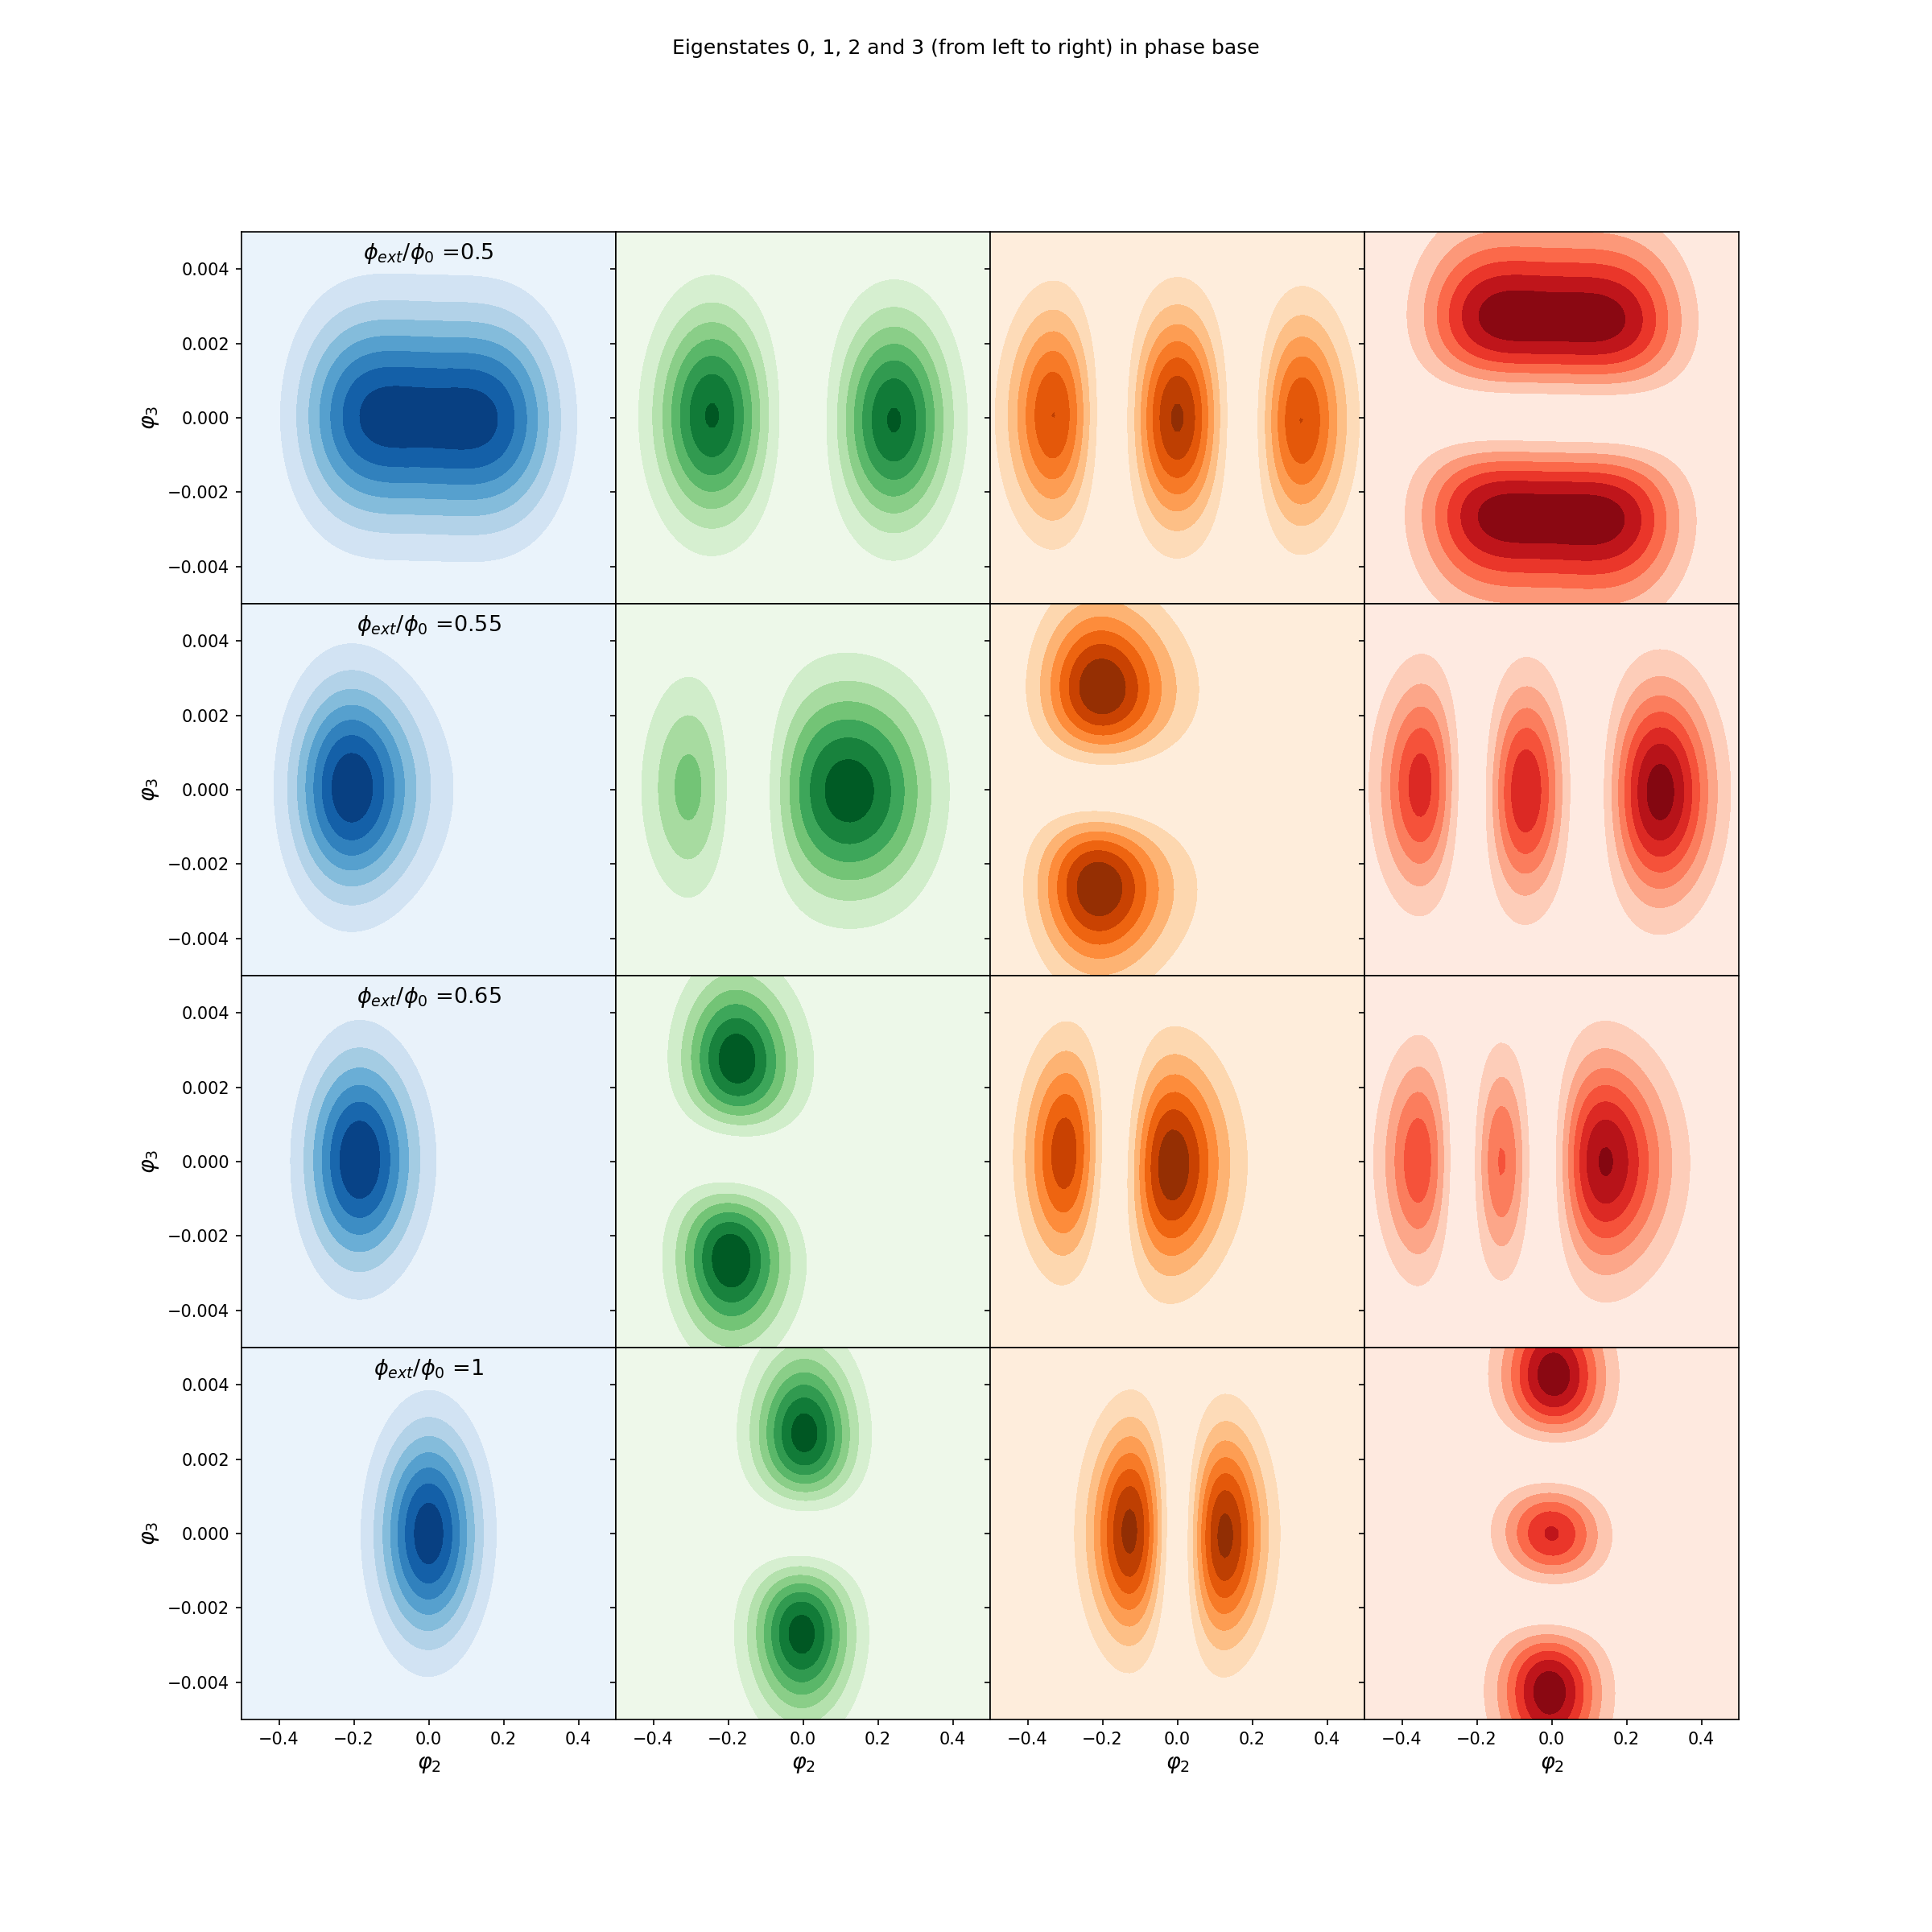

In [17]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4), sharey='row', sharex = 'col', dpi=150)

for i, ext_flux in enumerate(ext_flux_list):
    axs[i, 0].contourf(phi3, phi2, np.abs(state0_vs_ext_flux[i].T) ** 2, cmap="Blues", )
    axs[i, 1].contourf(phi3, phi2, np.abs(state1_vs_ext_flux[i].T) ** 2, cmap="Greens" )
    axs[i, 2].contourf(phi3, phi2, np.abs(state2_vs_ext_flux[i].T) ** 2, cmap="Oranges")
    axs[i, 3].contourf(phi3, phi2, np.abs(state3_vs_ext_flux[i].T) ** 2, cmap="Reds"   )
    for j in range(4):
        axs[-1, j].set_xlabel(r"$\varphi_2$", fontsize=13)
    axs[i, 0].set_ylabel(r"$\varphi_3$", fontsize=13)
    axs[i, 0].set_title('$\phi_{ext}/\phi_{0}$ ='+f'{ext_flux}', fontsize=13, y=0.9 )
fig.suptitle('Eigenstates 0, 1, 2 and 3 (from left to right) in phase base')
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
plt.show()

# Fluxonium-Resonator internal coupling in KIT's qubit

In [33]:
fluxonium.set_trunc_nums([20])
resonator.set_trunc_nums([20])
n_eig = 2

In [45]:
loop_fluxonium.set_flux(0)
_ = fluxonium.diag(n_eig)
_ = resonator.diag(n_eig)

In [46]:
H_eig = np.zeros((n_eig, n_eig), dtype=complex)
for i in range(n_eig):
    for j in range(n_eig):
        H_eig[i, j] = (fluxonium._evecs[i].dag()
                       * fluxonium.flux_op(0) * fluxonium._evecs[j]).data[0, 0]
sq_ext.decomposition_in_pauli_2x2(H_eig)

array([ 0.        ,  7.96390134, 16.21518122,  0.        ])

In [47]:
H_eig = np.zeros((n_eig, n_eig), dtype=complex)
for i in range(n_eig):
    for j in range(n_eig):
        φ_i = qt.Qobj(sq_ext.real_eigenvectors(fluxonium._evecs[i].__array__()))
        φ_j = qt.Qobj(sq_ext.real_eigenvectors(fluxonium._evecs[j].__array__()))
        H_eig[i, j] = (φ_i.dag() * fluxonium.flux_op(0) * φ_j ).data[0, 0]
sq_ext.decomposition_in_pauli_2x2(H_eig)

array([ 0.       , 18.0653211,  0.       ,  0.       ])

In [25]:
circuit.set_trunc_nums([1,15,15])
loop.set_flux(0.5)
_ = circuit.diag(2)

In [26]:
Δ = (circuit.efreqs[1]-circuit.efreqs[0])
Δ

1.9453602983437213

In [29]:
L_c = l / Δ * 1e-9
# E_L_c = (Φ_0/(2*np.pi))**2/L_c / h

In [50]:
Φ_f = sq_ext.decomposition_in_pauli_2x2(fluxonium.flux_op(0, basis='eig').__array__())[1]
Φ_f
# φ_f = Φ_f * 2*np.pi / Φ_0

18.065321100898494

In [37]:
Φ_r = sq_ext.decomposition_in_pauli_2x2(resonator.flux_op(0, basis='eig').__array__())[1]
# φ_r = Φ_r * 2*np.pi / Φ_0

In [38]:
g = Φ_r * Φ_f / L_c / GHz
# g = E_L_c * φ_r * φ_f
g

0.8297519217641446

In [49]:
g / Δ * 100

42.65286602541416

### Analytical approximation of the fluxonim-resonator coupling

In [15]:
φ_min = E_L_f / E_J * 0.73908513321516064166
φ_min 

1.5185241423478413

In [ ]:
g_an = (Φ_0 / 2*np.pi) * 